## Creating the CNN Model

In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os, cv2, random

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

In [6]:
# Importing the keras libraries
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from glob import glob

Using TensorFlow backend.


## Uploading the Dataset

In [7]:
print(os.getcwd())

D:\Documents\Personal\Nano Degrees\Machine Learning Engineer\MLND Project


## Setting the Initial Parameters

In [8]:
# Setting the initial parameters
train_dir = 'train/'
test_dir = 'test_stg1/'
rows = 224
cols = 224
fish_classes = os.listdir(train_dir)[1:]
channels = 3

In [9]:
print(fish_classes)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


## Acquiring the Images

In [10]:
def get_images(fish):
    images = [fish+'/'+im for im in os.listdir(train_dir+fish)]
    return images

In [11]:
files = []
y_all = []

for fish in fish_classes:
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    print('{0} number of fish in {1}'.format(len(fish_files),fish))

y_all = np.array(y_all)

1719 number of fish in ALB
200 number of fish in BET
117 number of fish in DOL
67 number of fish in LAG
465 number of fish in NoF
299 number of fish in OTHER
176 number of fish in SHARK
734 number of fish in YFT


(array([ 1719.,   200.,   117.,     0.,    67.,   465.,     0.,   299.,
          176.,   734.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

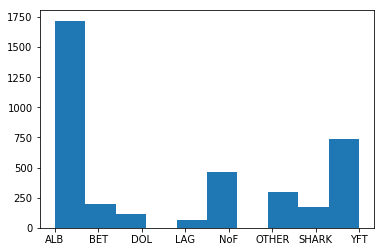

In [12]:
# Making a histogram for the analysis
plt.hist(y_all)

## Reading the Images

In [13]:
def read_image(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (cols, rows), interpolation = cv2.INTER_CUBIC)
    return im

In [14]:
X_all = np.ndarray((len(files), rows, cols, channels), dtype=np.uint8)

for i, im in enumerate(files): 
    X_all[i] = read_image(train_dir+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777
(3777, 224, 224, 3)


In [15]:
# Looking at the uniqe pictures
uniq = np.unique(y_all, return_index=True)
#for f, i in zip(uniq[0], uniq[1]):
#    plt.imshow(X_all[i])
#    plt.title(f)
#    plt.show()

## Converting in train and validation sets

In [16]:
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y_all)

In [17]:
X_train.shape

(3021, 224, 224, 3)

In [18]:
y_train.shape

(3021, 8)

## Using the approach of CNN
Since the PC is not fast enough, only a few layers will be created to get a good log loss ratio.

In [19]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_train /= 255
X_valid /= 255

In [20]:
# I will start by declaring a sequential layer
model = Sequential()
model.add(Dense(32, input_shape=(rows,cols,channels)))
model.add(Activation('relu'))

In [21]:
# Next I'll add a few convolutional layers and pooling layers
model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

In [22]:
model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

In [23]:
model.add(Dropout(0.25))

In [24]:
model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

In [25]:
model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))

In [26]:
model.add(Dropout(0.2))

In [27]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
__________

In [29]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1)

Epoch 1/5
3021/3021 [==============================] - 766s 254ms/step - loss: 1.7655 - acc: 0.4323A: 58:18 - lo
Epoch 2/5
3021/3021 [==============================] - 561s 186ms/step - loss: 1.4647 - acc: 0.5061
Epoch 3/5
3021/3021 [==============================] - 573s 190ms/step - loss: 1.0785 - acc: 0.6230
Epoch 4/5
3021/3021 [==============================] - 564s 187ms/step - loss: 0.6942 - acc: 0.7693
Epoch 5/5
3021/3021 [==============================] - 565s 187ms/step - loss: 0.4744 - acc: 0.8481


In [107]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_valid, preds)))

756/756 [==============================] - 47s 62ms/step
Validation Log Loss: 0.32216529096371455


In [123]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Accuracy Score: {} %'.format(score[1]*100))

Accuracy Score: 88.22751322751323 %


### Comparing the original with the validation to view the correctly classified

In [244]:
print(pd.DataFrame(preds, columns=fish_classes).head())
print(np.argmax(preds[3]))
print(preds.shape[0])

        ALB           BET           DOL           LAG       NoF         OTHER  \
0  0.468378  5.071857e-01  5.290388e-04  2.179999e-04  0.012196  7.236036e-05   
1  0.008324  2.511151e-06  9.132025e-06  9.892884e-01  0.000104  5.999771e-04   
2  0.959811  8.254110e-07  1.266929e-11  1.387556e-11  0.040173  5.553948e-11   
3  0.995398  1.213474e-04  2.344814e-06  3.357009e-07  0.004215  2.619514e-04   
4  1.000000  2.138292e-02  7.971452e-03  3.466655e-03  0.086652  2.002653e-03   

          SHARK           YFT  
0  4.727925e-04  1.094817e-02  
1  8.222574e-06  1.664198e-03  
2  1.285645e-14  1.504066e-05  
3  1.335214e-06  1.296018e-07  
4  4.303787e-04  6.434791e-02  
0
756


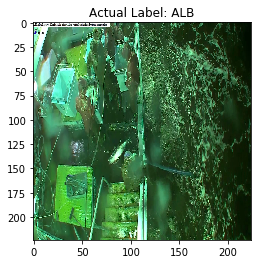

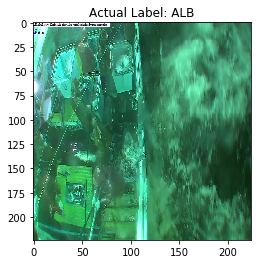

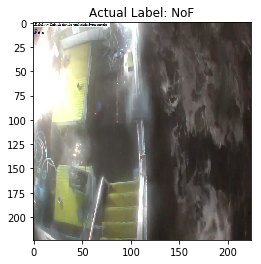

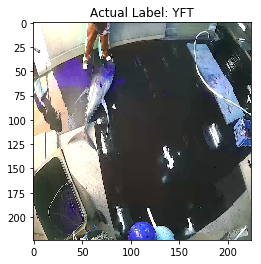

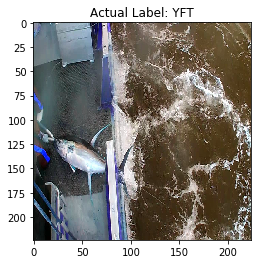

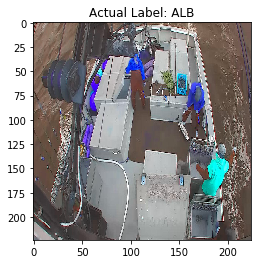

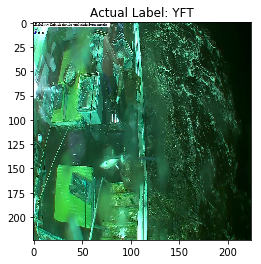

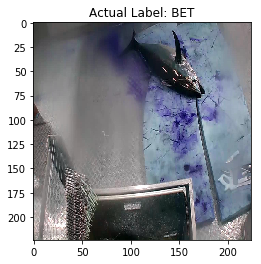

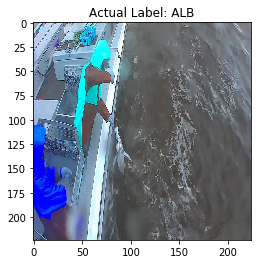

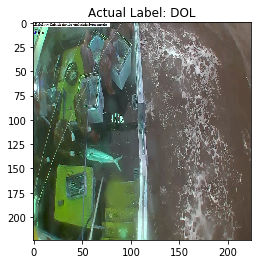

In [253]:
sample_list = random.sample(range(0, len(X_valid)), 10)

for i in sample_list:
    plt.imshow(X_valid[i])
    fc = fish_classes[np.argmax(y_valid[i])]
    plt.title('Actual Label: '+fc)
    plt.show()

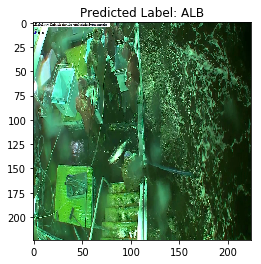

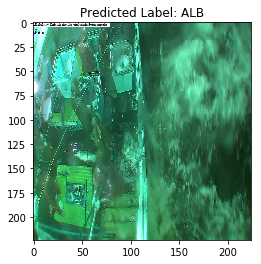

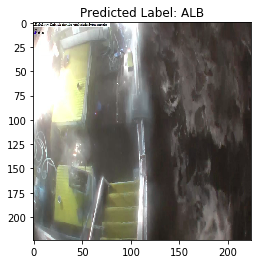

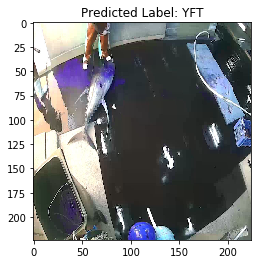

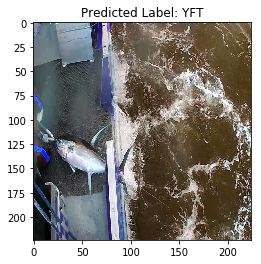

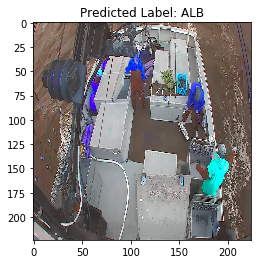

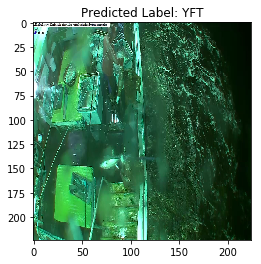

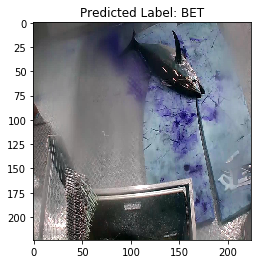

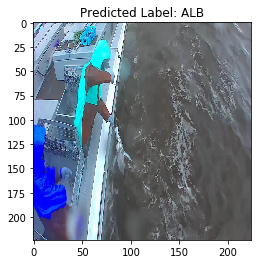

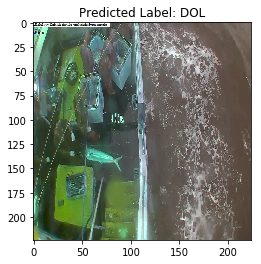

In [254]:
for i in sample_list:
    plt.imshow(X_valid[i])
    fcp = fish_classes[np.argmax(preds[i])]
    plt.title('Predicted Label: '+fcp)
    plt.show()

## Predicting the result on the test set

In [32]:
test_files = [im for im in os.listdir(test_dir)]
test = np.ndarray((len(test_files), rows, cols, channels), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(test_dir+im)

In [33]:
test.shape

(1000, 224, 224, 3)

In [34]:
test = test.astype('float32')
test /= 255

In [35]:
test_preds = model.predict(test, verbose=1)

1000/1000 [==============================] - 59s 59ms/step


In [119]:
len(test_preds)

1000

In [36]:
submission = pd.DataFrame(test_preds, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.to_csv("submissions.csv",index = False)

In [37]:
submission.head(10)

image       ALB       BET           DOL       LAG       NoF  \
0  img_00005.jpg  0.044367  0.000140  1.463146e-01  0.001924  0.800206   
1  img_00007.jpg  0.826567  0.000171  9.756978e-04  0.006841  0.007295   
2  img_00009.jpg  0.534416  0.091934  1.093753e-03  0.009675  0.135407   
3  img_00018.jpg  0.978293  0.000004  7.879991e-04  0.000536  0.005136   
4  img_00027.jpg  0.049362  0.000143  5.274771e-04  0.000007  0.003055   
5  img_00030.jpg  0.321785  0.000582  7.951650e-04  0.007822  0.593880   
6  img_00040.jpg  0.199920  0.159207  1.383379e-02  0.009798  0.048673   
7  img_00046.jpg  0.999779  0.000003  3.370266e-07  0.000010  0.000082   
8  img_00053.jpg  0.944717  0.003808  3.120618e-03  0.003780  0.009832   
9  img_00071.jpg  0.276028  0.004403  1.050309e-03  0.598439  0.035401   

      OTHER         SHARK       YFT  
0  0.005410  2.015656e-06  0.001637  
1  0.004071  1.637230e-05  0.154062  
2  0.179595  3.755675e-03  0.044123  
3  0.000188  1.524414e-06  0.015055  
4  0.911397  1.307274e-05  0.035495  
5  0.000158  4.055606e-03  0.070922  
6  0.179558  2.102910e-02  0.367981  
7  0.000011  1.561031e-08  0.000115  
8  0.027139  9.953935e-04  0.006608  
9  0.019819  7.426924e-05  0.064785

### Using Keras InceptionV3

In [255]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [72]:
base_model_2 = VGG16(weights = 'imagenet', include_top=True)

In [74]:
base_model_3 = VGG19(weights = 'imagenet')

574717952/574710816 [==============================] - 2181s 4us/step


In [419]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer for the FISH_CLASSES = 8 we are trying to predict
predictions = Dense(len(fish_classes), activation='sigmoid')(x)

# this is the model we will train
model1 = Model(input=base_model.input, output=predictions)

C:\Users\haari\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # This is added back by InteractiveShellApp.init_path()


In [420]:
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer='RMSprop', loss='categorical_crossentropy')

In [421]:
model1.fit(X_train, y_train, batch_size=64, epochs=5,
              validation_split=0.2, verbose=1, shuffle=False)

Train on 2416 samples, validate on 605 samples
Epoch 1/5
2416/2416 [==============================] - 511s 211ms/step - loss: 2.0757 - val_loss: 2.0039
Epoch 2/5
2416/2416 [==============================] - 531s 220ms/step - loss: 1.9477 - val_loss: 1.8876
Epoch 3/5
2416/2416 [==============================] - 533s 221ms/step - loss: 1.8416 - val_loss: 1.8367
Epoch 4/5
2416/2416 [==============================] - 533s 221ms/step - loss: 1.7267 - val_loss: 1.6742
Epoch 5/5
2416/2416 [==============================] - 533s 220ms/step - loss: 1.5416 - val_loss: 1.5732


In [422]:
N=172

for layer in model1.layers[:N]:
    layer.trainable = False
for layer in model1.layers[N:]:
    layer.trainable = True

In [423]:
model1.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [424]:
model1.fit(X_train, y_train, batch_size=64, epochs=5,
              validation_split=0.2, verbose=1, shuffle=False)

Train on 2416 samples, validate on 605 samples
Epoch 1/5
2416/2416 [==============================] - 750s 310ms/step - loss: 1.4161 - val_loss: 1.4562
Epoch 2/5
2416/2416 [==============================] - 753s 312ms/step - loss: 1.2927 - val_loss: 1.4379
Epoch 3/5
2416/2416 [==============================] - 757s 313ms/step - loss: 1.2612 - val_loss: 1.4269
Epoch 4/5
2416/2416 [==============================] - 763s 316ms/step - loss: 1.2413 - val_loss: 1.4180
Epoch 5/5
2416/2416 [==============================] - 760s 315ms/step - loss: 1.2219 - val_loss: 1.4035


In [425]:
loss_and_metrics = model1.evaluate(X_valid, y_valid, batch_size=64)
print ("Validation Logloss: ", loss_and_metrics)

756/756 [==============================] - 149s 198ms/step
Validation Logloss:  1.36437859485


In [426]:
test_preds = model1.predict(test, verbose=1)

1000/1000 [==============================] - 197s 197ms/step


In [427]:
t3 = test_preds.sum(axis = 0).round().astype(int).tolist()

In [432]:
test_preds.sum(axis = 0)

array([ 1000.  ,    71.01,    38.92,     4.42,   983.58,   112.39,
          28.1 ,   923.62], dtype=float32)

In [429]:
sum(t3)

3162

In [441]:
submission2 = pd.DataFrame(test_preds, columns=fish_classes)
submission2.insert(0, 'image', test_files)
submission2.head()

image  ALB       BET       DOL           LAG       NoF     OTHER  \
0  img_00005.jpg  1.0  0.004957  0.002672  1.174110e-05  0.994402  0.022765   
1  img_00007.jpg  1.0  0.185913  0.008855  1.107834e-04  0.992499  0.010496   
2  img_00009.jpg  1.0  0.102227  0.000109  1.073293e-05  0.995705  0.180871   
3  img_00018.jpg  1.0  0.006411  0.000048  4.029538e-07  0.999788  0.000651   
4  img_00027.jpg  1.0  0.002972  0.000195  4.559217e-06  0.932915  0.052132   

      SHARK       YFT  
0  0.000195  0.930349  
1  0.004518  0.981581  
2  0.000038  0.953828  
3  0.000018  0.868669  
4  0.020141  0.967447

## Making the confusion matrices

In [415]:
t1 = y_valid.sum(axis = 0).astype(int).tolist()
print(t1)

[344, 40, 24, 13, 93, 60, 35, 147]


In [416]:
t2 = preds.sum(axis = 0).round().astype(int).tolist()

In [417]:
cc = []
for i,j in zip(t1,fish_classes):
    g = np.tile(j, i)
    cc.extend(g)

In [418]:
dd = []
for i,j in zip(t2,fish_classes):
    g = np.tile(j, i)
    dd.extend(g)

In [404]:
sum(t1)

756

In [405]:
sum(t2)

756

In [411]:
cm = confusion_matrix(cc, dd, labels=fish_classes)
print(cm)

[[344   0   0   0   0   0   0   0]
 [ 40   0   0   0   0   0   0   0]
 [  3  21   0   0   0   0   0   0]
 [  0   6   7   0   0   0   0   0]
 [  0   0  18  13  62   0   0   0]
 [  0   0   0   0  30  30   0   0]
 [  0   0   0   0   0  19  16   0]
 [  0   0   0   0   0   0  21 126]]


In [412]:
# Graph of confusion Matrix
import itertools
np.set_printoptions(precision=2)
print(__doc__)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[344   0   0   0   0   0   0   0]
 [ 40   0   0   0   0   0   0   0]
 [  3  21   0   0   0   0   0   0]
 [  0   6   7   0   0   0   0   0]
 [  0   0  18  13  62   0   0   0]
 [  0   0   0   0  30  30   0   0]
 [  0   0   0   0   0  19  16   0]
 [  0   0   0   0   0   0  21 126]]


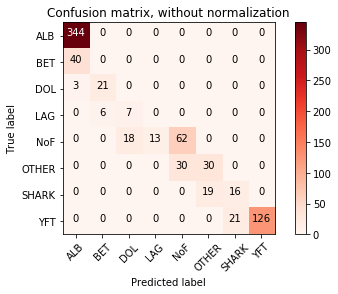

In [413]:
plt.figure()
plot_confusion_matrix(cm, classes=fish_classes,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.12  0.88  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.46  0.54  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.19  0.14  0.67  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.5   0.5   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.54  0.46  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.14  0.86]]


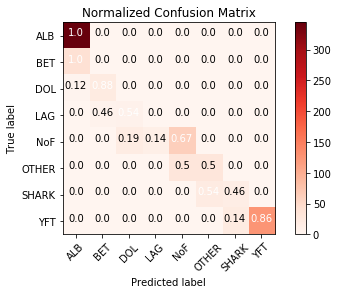

In [414]:
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=fish_classes, normalize = True, title= "Normalized Confusion Matrix")
plt.show()

In [1]:
submission

NameError: name 'submission' is not defined